Pre-processing of fire scar data using rasterio:
1. Ensure CRS match
2. Crop image to 512 by 512, centered on fire ignition point
3. Add edge padding filled with nan values for pixels outside bounds
4. Save new image as .tif file
5. Create scar label mask with same dimensions and center, and save as .tif file

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
import geopandas as gdp
from rasterio.warp import reproject, Resampling
from rasterio.transform import rowcol
from rasterio.windows import Window


In [3]:
# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx") #excel meta-data file with file names and locations
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar available
df = df[df['Region_CONAF'] == 'Maule'] # Filter to just Maule
df = df.reset_index()


In [4]:
# Pick an example fire event

fire_id = 17 # look at first event
example_fire = df.loc[fire_id]

fire_season = example_fire["FireSeason"]
folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
file_names = {
        "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
        "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
        "Severity": (example_fire["SeverityImgName"], "Blues"),
    }

#save paths to images
pre_fire_path = os.path.join(folder, example_fire["PreFireImgName"])
post_fire_path = os.path.join(folder, example_fire["PostFireImgName"])
fire_scar_vector_path = os.path.join(folder, example_fire["FireScarVectorName"])
fire_scar_path = os.path.join(folder, example_fire["FireScarImgName"])
severity_path = os.path.join(folder, example_fire["SeverityImgName"])

In [5]:
example_fire

index                                                            33
FireID                                                     ID100174
FireSeason                                                     2003
RegionCode                                                    CL-ML
Region_CONAF                                                  Maule
FireName_CONAF                                      LOS CASTANOS II
Area_CONAF [ha]                                                34.0
IgnitionDate_CONAF                                       2003-04-04
ControlDate_CONAF                                        2003-04-04
Latitude [°]                                               -35.0834
Longitude [°]                                              -71.1993
FireScar                                                          1
FolderLocation                            FireScar_CL-ML_Maule_2003
FireScarImgName           FireScar_CL-ML_ID100174_u600_20030404.tif
PreFireImgName             ImgPreF_CL-ML_ID10017

In [6]:
# Read fire scar shape file as geo data frame
fire_scar_vector = gdp.read_file(fire_scar_vector_path)
fire_scar_vector = fire_scar_vector.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)


In [315]:
fire_scar = rasterio.open(fire_scar_path)
severity = rasterio.open(severity_path)

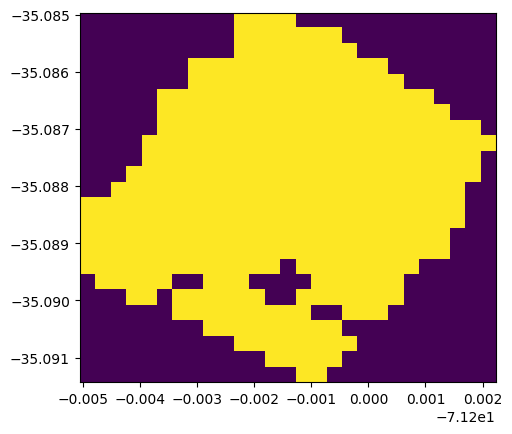

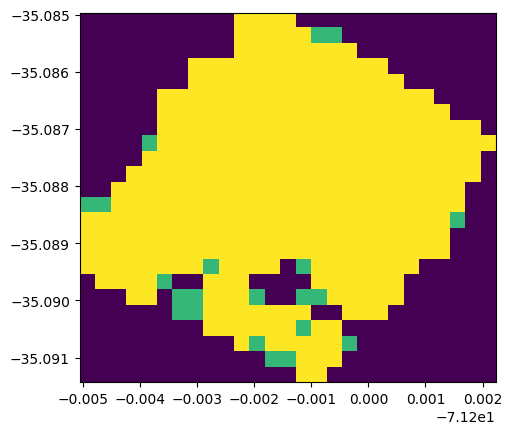

<Axes: >

In [316]:
show(fire_scar)
show(severity)

In [317]:
fire_scar.read(1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0],
       [0, 0, 0, 1, 

In [318]:
# Center coordinates of severity scar:
severity.xy(severity.height // 2, severity.width // 2)

(-71.2014126503616, -35.08832974500113)

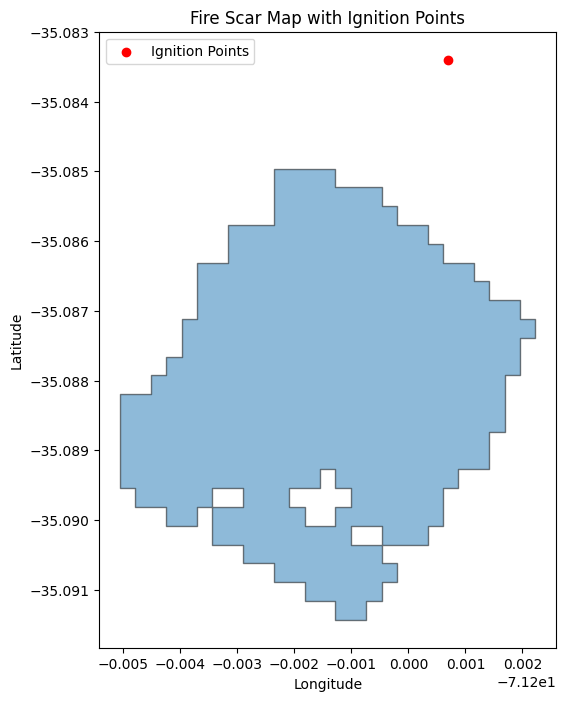

In [319]:
# Visualize fire scar with ignition point overlay

# Fire scar
ax = fire_scar_vector.plot(figsize=(8, 8), edgecolor="black", alpha=0.5)

# ignition point
plt.scatter(example_fire['Longitude [°]'],example_fire['Latitude [°]'], color='red', label='Ignition Points')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Fire Scar Map with Ignition Points")
plt.show()

/Users/abbystokes/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


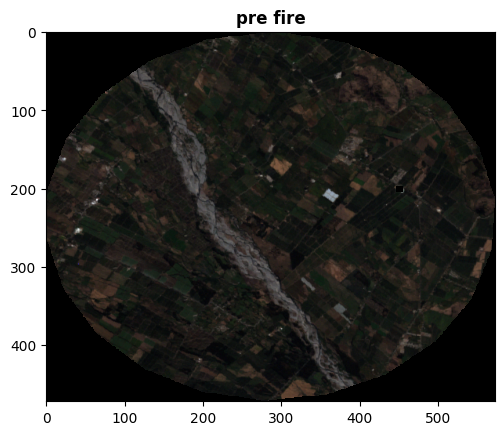

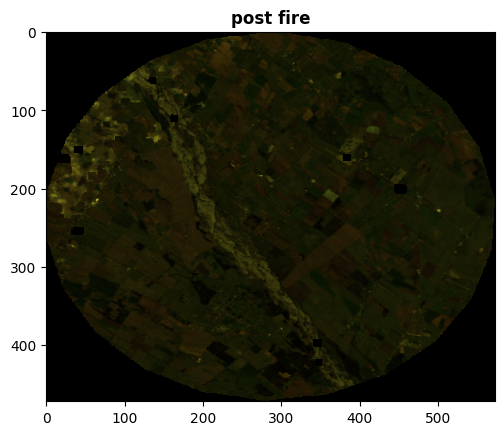

<Axes: title={'center': 'post fire'}>

In [320]:
from rasterio.plot import show, adjust_band

# Read in pre and post image data as rasterio and visualize in RGB

pre_fire = rasterio.open(pre_fire_path)
imgdata = np.array([adjust_band(pre_fire.read(i)) for i in (3,2,1)])
show(imgdata, title = 'pre fire')  # factor 3 to increase brightness
post_fire = rasterio.open(post_fire_path)
imgdata = np.array([adjust_band(post_fire.read(i)) for i in (3,2,1)])
show(imgdata, title='post fire')

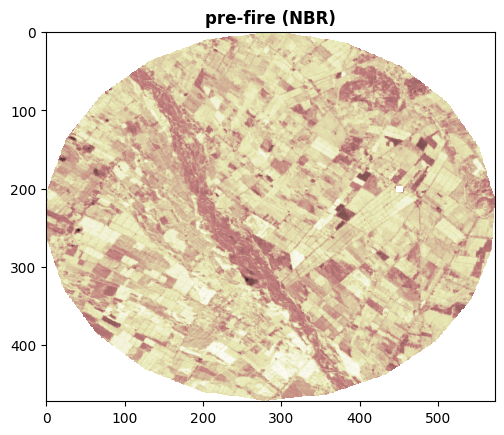

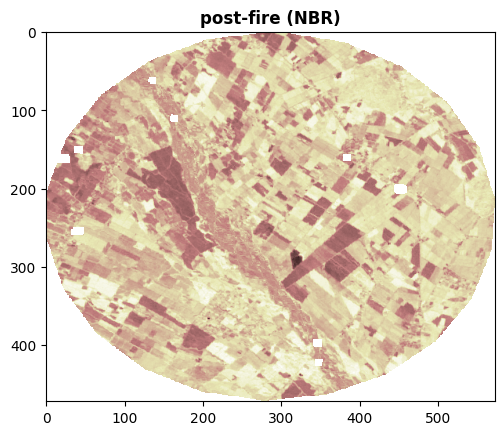

<Axes: title={'center': 'post-fire (NBR)'}>

In [321]:
# Visualiza in NBR band
show(pre_fire.read(8),cmap='pink', title='pre-fire (NBR)')
show(post_fire.read(8),cmap='pink', title='post-fire (NBR)')

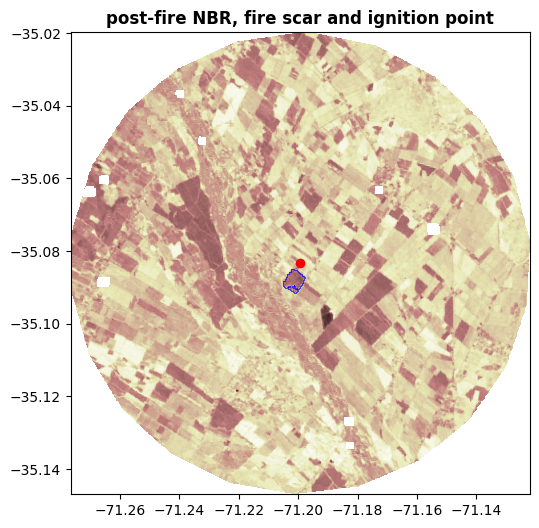

In [322]:
transform = pre_fire.transform
# Get raster bounds 
left, bottom, right, top = rasterio.transform.array_bounds(
    pre_fire.height, pre_fire.width, transform
)
fig, ax = plt.subplots(figsize=(10, 6))
show(post_fire.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top],title = 'post-fire NBR, fire scar and ignition point')

# Overlay fire scar on the same plot
fire_scar_vector.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)
plt.scatter(fire_scar_vector['IgnLon'], fire_scar_vector['IgnLat'], color='red', label='Ignition Point')

In [339]:
#### Pre-processing: cropping image to 512x512 centered on ignition point ####
# edge padding with nan

target_lat = fire_scar_vector['IgnLat'][0]
target_lon = fire_scar_vector['IgnLon'][0]

with rasterio.open(post_fire_path) as src:
    xsize, ysize = 512, 512
    
    target_x, target_y = src.index(target_lon, target_lat)
    xoff = target_x - xsize // 2
    yoff = target_y - ysize // 2

    window = Window(xoff, yoff, xsize, ysize).round_offsets()

    transform = src.window_transform(window) # Upadte transform
    
    crs = src.crs
    profile = src.profile
    profile.update({
        'height': ysize,
        'width': xsize,
        'transform': transform
    })

    data = src.read(window=window, boundless=True, fill_value=np.nan) # Pad outside values with nan

    # Write to new file and save tif
    with rasterio.open('merged.tif', 'w', **profile) as dst:
        dst.write(data)


In [340]:
#Check shape of output file - should be 512 x 512
rasterio.open('merged.tif').shape

(512, 512)

In [341]:
# Check that nans were properly filled
cropped = rasterio.open('merged.tif')
cropped.read(1)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

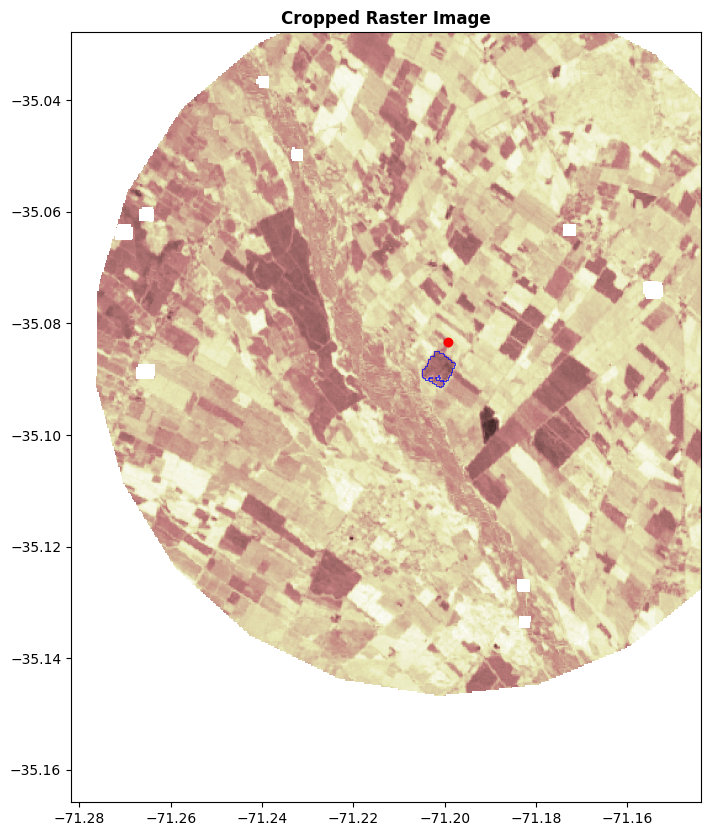

In [342]:
# Visual check of image cropping
cropped_src = rasterio.open('merged.tif')
transform = cropped_src.transform

# Get raster bounds (left, bottom, right, top) in geographic coordinates
left, bottom, right, top = rasterio.transform.array_bounds(
    cropped_src.height, cropped_src.width, transform
)

fig, ax = plt.subplots(figsize=(10, 10))

#8th band is NBR
show(cropped_src.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top], title="Cropped Raster Image")
fire_scar_vector.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=.5)
plt.scatter(fire_scar_vector['IgnLon'], fire_scar_vector['IgnLat'], color='red', label='Ignition Points')


Note: Its okay that a lot of our image is nan values (white), the CNN will know not to focus on those areas

In [343]:
### Creating fire scar mask (ground truth label)
# Using reproject rasterio function
#original image
with rasterio.open('merged.tif') as cropped_src:
    dst_crs = cropped_src.crs
    dst_transform = cropped_src.transform
    dst_shape = cropped_src.shape
    dst_meta = cropped_src.meta.copy()

#fire scar raster
with rasterio.open(fire_scar_path) as fire_src:
    fire_scar_data = fire_src.read(1)
    src_crs = fire_src.crs
    src_transform = fire_src.transform

#empty array to hold the resampled fire scar
resampled_fire_scar = np.zeros(dst_shape, dtype=fire_scar_data.dtype)
# Reproject fire scar to match cropped_src
reproject(
    source=fire_scar_data,
    destination=resampled_fire_scar,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest  # use nearest to preserve binary values
)

# Update fire scar metadata
dst_meta.update({
    'height': dst_shape[0],
    'width': dst_shape[1],
    'transform': dst_transform,
    'crs': dst_crs,
    'count': 1,
    'dtype': fire_scar_data.dtype
})

# Save the reprojected/resampled fire scar mask
with rasterio.open('mask.tif', 'w', **dst_meta) as dst:
    dst.write(resampled_fire_scar, 1)


In [344]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

# Read base image and aligned fire scar
with rasterio.open('merged.tif') as base_src:
    base_img = base_src.read(8)
    transform = base_src.transform

with rasterio.open('mask.tif') as fire_src:
    fire_img = fire_src.read(1)


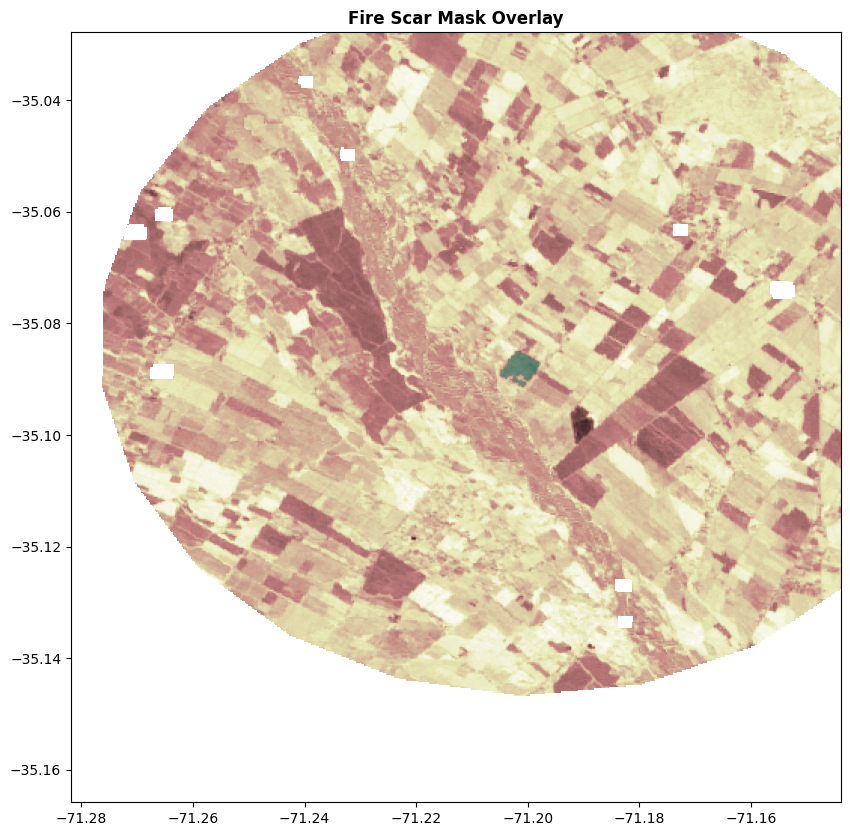

In [345]:
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(10, 10))
# Mask 0s for transparency in plot
masked_fire = np.ma.masked_where(fire_img == 0, fire_img)

# Show the base image
show(base_img, transform=transform, ax=ax, cmap='pink', title='Fire Scar Mask Overlay')

# Overlay the masked fire layer
show(masked_fire, transform=transform, ax=ax, cmap='Dark2', alpha=0.5)

plt.show()